## Load dataset and train classifier

In [1]:
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

In [2]:
from intabs.dataset import InnDataSet
data_name = "adult"
dataset = InnDataSet(data_name)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.
 [lazy_loader.py _load]


In [3]:
from intabs.classifier_binary import cross_validation, train_clf, InnModel
d = dataset
num_h_neurons = 20
epochs = 15
cross_validation(d, num_h_neurons, epochs, data_name)

Using cuda device
accuracy: 0.8465697317223018+-0.006021585329471834


In [4]:
torch_model = train_clf(d.X1_train, d.y1_train, d.X1_test, d.y1_test, num_h_neurons, epochs, data_name, save_clf=False, load_clf=False)
model = InnModel(d, torch_model, num_h_neurons)

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.876     0.936     0.905     14854
good credit (1)      0.742     0.581     0.651      4678

       accuracy                          0.851     19532
      macro avg      0.809     0.758     0.778     19532
   weighted avg      0.844     0.851     0.845     19532

Evaluations on testing data

                  precision    recall  f1-score   support

 bad credit (0)      0.867     0.934     0.899      3713
good credit (1)      0.722     0.546     0.622      1170

       accuracy                          0.841      4883
      macro avg      0.795     0.740     0.761      4883
   weighted avg      0.832     0.841     0.833      4883



## Experiments 1

First, get $\delta$ value using incremental retraining, and get $\delta$ value using validation set

In [5]:
from intabs.evaluation import get_delta_incremental_training, get_retrained_models_and_validation_set, test_delta_with_val_set
percentages, delta_magnitudes = get_delta_incremental_training(d, model)
inc_delta = delta_magnitudes[5].round(5) # select the delta value corresponding to retraining on 10% size of original data

100%|██████████| 51/51 [00:59<00:00,  1.17s/it]


In [6]:
model.raw_model.to("cpu")
rt_models, val_set, val_y_set = get_retrained_models_and_validation_set(d, model)

100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


In [7]:
val_delta = 0.02
print(test_delta_with_val_set(d, model, val_delta, val_set, rt_models))

0it [00:00, ?it/s]

Set parameter Username
[INFO] Set parameter Username [intabs.py __init__]
Academic license - for non-commercial use only - expires 2025-02-14
[INFO] Academic license - for non-commercial use only - expires 2025-02-14 [intabs.py __init__]


4547it [02:10, 34.82it/s]

True


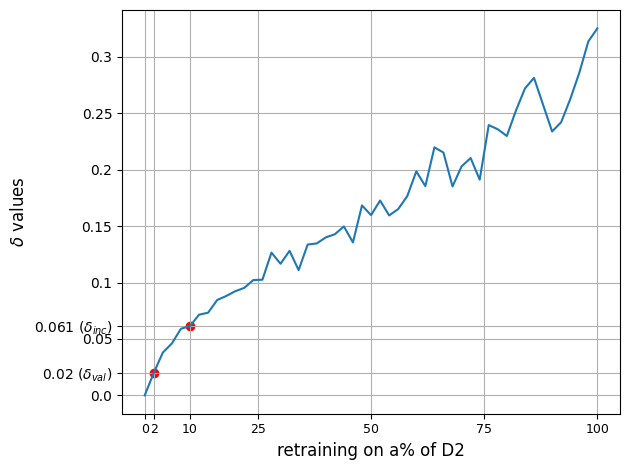

In [8]:
# plot
from intabs.evaluation import plot_deltas
plot_deltas(val_delta, inc_delta, percentages, delta_magnitudes, data_name)

## Experiments 2

Evaluating $\Delta$-robustness

In [9]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from intabs.evaluation import *
test_set, test_set_df, test_set_full_df = get_test_inputs(d, model, 50)

In [10]:
from intabs.methods import roar, gce, mce, gce_r, mce_r, proto_r, rnce
deltas_plot = get_deltas_plot(inc_delta, val_delta)

In [11]:
roar_ces_plot = roar(test_set_full_df, model, lr=0.02, lambda_=0.001, delta_max=inc_delta)
roar_delta_validity = delta_robustness_test_for_plots(d, model, roar_ces_plot, deltas_plot)

In [12]:
gce_ces_plot = gce(test_set, model)
gce_delta_validity = delta_robustness_test_for_plots(d, model, gce_ces_plot, deltas_plot)

In [13]:
mce_ces_plot = mce(test_set, d, model)
mce_delta_validity = delta_robustness_test_for_plots(d, model, mce_ces_plot, deltas_plot)

In [14]:
proto_ces_plot = proto_r(test_set, d, model, plain=True)
proto_delta_validity = delta_robustness_test_for_plots(d, model, proto_ces_plot, deltas_plot)

0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]
[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]


50it [25:20, 30.42s/it]


In [15]:
gcer_ces_plot = gce_r(test_set, d, model, delta=inc_delta)
gcer_delta_validity = delta_robustness_test_for_plots(d, model, gcer_ces_plot, deltas_plot)

50it [06:38,  7.97s/it]


In [16]:
mcer_ces_plot = mce_r(test_set, d, model, delta=inc_delta)
mcer_delta_validity = delta_robustness_test_for_plots(d, model, mcer_ces_plot, deltas_plot)

50it [05:35,  6.71s/it]


In [17]:
protor_ces_plot = proto_r(test_set, d, model, delta=inc_delta, plain=False, plain_proto_ces=proto_ces_plot)
protor_delta_validity = delta_robustness_test_for_plots(d, model, protor_ces_plot, deltas_plot)

50it [1:27:40, 105.20s/it]


In [18]:
rnce_ces_plot = rnce(test_set, d, model, delta=inc_delta)
rnce_delta_validity = delta_robustness_test_for_plots(d, model, rnce_ces_plot, deltas_plot)

9091it [07:46, 19.50it/s]


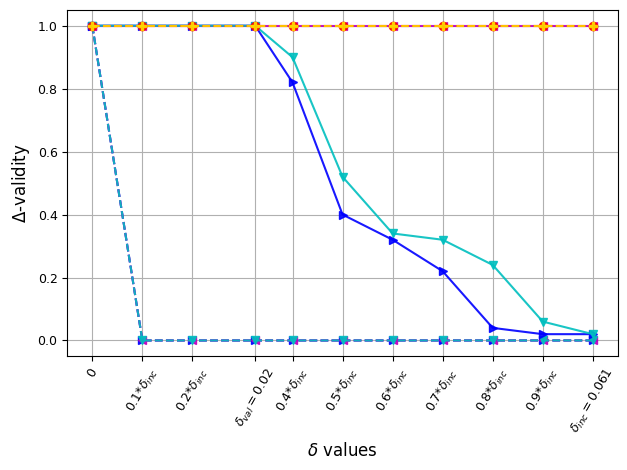

In [19]:
plot_delta_validity(deltas_plot, val_delta, gce_delta_validity, mce_delta_validity, proto_delta_validity, roar_delta_validity, gcer_delta_validity, mcer_delta_validity, protor_delta_validity, rnce_delta_validity, True, data_name)

## Experiments 3

Benchmarking CEs


Performance drops after consecutive runs, save and load results after restartting

In [20]:
from intabs.evaluation import *
from intabs.methods import run_exps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
rt_models_eval = get_retrained_models_all(d, model, num_h_neurons=num_h_neurons, epochs=epochs)

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


In [21]:
from intabs.methods import run_exps_all_once
res_1 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=1050,
                               run_id=1)


===== running experiments 1/5 =====
===== running non-robust baselines 1-4/17 =====


20it [14:18, 42.92s/it]


===== running robust baselines 5-7/17 =====


20it [02:26,  7.32s/it]
20it [00:01, 19.92it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:38,  7.91s/it]
20it [07:48, 23.40s/it]
20it [51:37, 154.86s/it]
9091it [09:12, 16.47it/s]
20it [00:18,  1.07it/s]


===== running our methods 13-17/17, validation delta =====


20it [02:24,  7.25s/it]
20it [03:37, 10.89s/it]
20it [1:00:00, 180.04s/it]
9091it [08:21, 18.12it/s]
20it [00:24,  1.24s/it]


In [22]:
res_2 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=7050,
                               run_id=2)

===== running experiments 2/5 =====
===== running non-robust baselines 1-4/17 =====


20it [27:39, 82.98s/it]


===== running robust baselines 5-7/17 =====


20it [02:22,  7.13s/it]
20it [00:01, 16.98it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:46,  8.32s/it]
20it [12:19, 36.97s/it]
20it [1:41:13, 303.69s/it]
9091it [14:04, 10.77it/s]
20it [00:22,  1.12s/it]


===== running our methods 13-17/17, validation delta =====


20it [02:24,  7.21s/it]
20it [06:19, 18.96s/it]
20it [2:06:09, 378.49s/it]
9091it [11:31, 13.15it/s]
20it [00:32,  1.64s/it]


In [24]:
res_3 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3050,
                               run_id=3)

===== running experiments 3/5 =====
===== running non-robust baselines 1-4/17 =====


20it [08:47, 26.35s/it]


===== running robust baselines 5-7/17 =====


20it [02:26,  7.34s/it]
20it [00:00, 42.04it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:46,  8.33s/it]
20it [01:55,  5.75s/it]
20it [30:40, 92.02s/it] 
9091it [05:20, 28.32it/s]
20it [00:12,  1.59it/s]


===== running our methods 13-17/17, validation delta =====


20it [02:18,  6.94s/it]
20it [01:07,  3.35s/it]
20it [32:33, 97.67s/it] 
9091it [05:39, 26.78it/s]
20it [00:16,  1.18it/s]


In [11]:
res_4 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3990,
                               run_id=4)

===== running experiments 4/5 =====
===== running non-robust baselines 1-4/17 =====


0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]
[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]


20it [10:27, 31.40s/it]


===== running robust baselines 5-7/17 =====


20it [02:59,  8.97s/it]
20it [00:00, 84.68it/s]
20it [00:00, 49.66it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:51,  8.56s/it]
20it [01:35,  4.79s/it]
20it [33:43, 101.17s/it]
10782it [06:38, 27.08it/s]
20it [00:13,  1.52it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:47,  5.36s/it]
20it [00:46,  2.31s/it]
20it [29:36, 88.81s/it] 
10782it [06:04, 29.56it/s]
20it [00:13,  1.47it/s]


In [27]:
res_5 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=6666,
                               run_id=5)

===== running experiments 5/5 =====
===== running non-robust baselines 1-4/17 =====
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14


0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]
[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where [deprecation.py new_func]


20it [10:04, 30.21s/it]


===== running robust baselines 5-7/17 =====


20it [02:56,  8.83s/it]
20it [00:00, 95.49it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:42,  8.14s/it]
20it [02:04,  6.23s/it]
20it [32:02, 96.14s/it]
6501it [03:51, 28.10it/s]
20it [00:16,  1.23it/s]


===== running our methods 13-17/17, validation delta =====


20it [02:12,  6.62s/it]
20it [00:59,  3.00s/it]
20it [26:42, 80.11s/it]
6501it [03:28, 31.25it/s]
20it [00:13,  1.51it/s]


In [64]:
mean_res, std_res = run_exps(res_1, res_2, res_3, res_4, res_5)

average results
+--------------+------------+--------+--------+-------+--------------+--------------+
| name         |   coverage |   cost |    lof |   vm2 |   vdelta-val |   vdelta-inc |
+==============+============+========+========+=======+==============+==============+
| gce          |       1    |  0.016 |  1.286 | 0.51  |         0    |        0     |
| mce          |       1    |  0.009 |  1.408 | 0.485 |         0    |        0     |
| proto        |       1    |  0.011 |  1.436 | 0.611 |         0.01 |        0     |
| nnce         |       1    |  0.032 |  1.335 | 0.761 |         0.02 |        0.02  |
| roar         |       0.98 |  0.877 | 12.539 | 1     |         1    |        0.948 |
| rbr          |       1    |  0.025 |  1.331 | 0.901 |         0    |        0     |
| stable-ce    |       1    |  0.046 |  1.267 | 0.987 |         0.2  |        0.04  |
| gce-r        |       1    |  0.051 |  1.645 | 1     |         1    |        0     |
| mce-r        |       1    |  0.062 |